In [1]:
# 模型训练
import numpy as np
import pandas as pd
import os
import tqdm
import datetime
import time

base_path = 'stock'

market_map = {'主板':0, '中小板':1}
exchange_map = {'SZSE':0, 'SSE':1}
is_hs_map = {'S':0, 'N':1, 'H':2}

area_map = {'深圳': 0, '北京': 1, '吉林': 2, '江苏': 3, '辽宁': 4, '广东': 5, '安徽': 6, '四川': 7, '浙江': 8,
            '湖南': 9, '河北': 10, '新疆': 11, '山东': 12, '河南': 13, '山西': 14, '江西': 15, '青海': 16, 
            '湖北': 17, '内蒙': 18, '海南': 19, '重庆': 20, '陕西': 21, '福建': 22, '广西': 23, '天津': 24, 
            '云南': 25, '贵州': 26, '甘肃': 27, '宁夏': 28, '黑龙江': 29, '上海': 30, '西藏': 31}

industry_map = {'银行': 0, '全国地产': 1, '生物制药': 2, '环境保护': 3, '区域地产': 4, '酒店餐饮': 5, '运输设备': 6, 
 '综合类': 7, '建筑工程': 8, '玻璃': 9, '家用电器': 10, '文教休闲': 11, '其他商业': 12, '元器件': 13, 
 'IT设备': 14, '其他建材': 15, '汽车服务': 16, '火力发电': 17, '医药商业': 18, '汽车配件': 19, '广告包装': 20, 
 '轻工机械': 21, '新型电力': 22, '饲料': 23, '电气设备': 24, '房产服务': 25, '石油加工': 26, '铅锌': 27, '农业综合': 28,
 '批发业': 29, '通信设备': 30, '旅游景点': 31, '港口': 32, '机场': 33, '石油贸易': 34, '空运': 35, '医疗保健': 36,
 '商贸代理': 37, '化学制药': 38, '影视音像': 39, '工程机械': 40, '软件服务': 41, '证券': 42, '化纤': 43, '水泥': 44, 
 '专用机械': 45, '供气供热': 46, '农药化肥': 47, '机床制造': 48, '多元金融': 49, '百货': 50, '中成药': 51, '路桥': 52, 
 '造纸': 53, '食品': 54, '黄金': 55, '化工原料': 56, '矿物制品': 57, '水运': 58, '日用化工': 59, '机械基件': 60, 
 '汽车整车': 61, '煤炭开采': 62, '铁路': 63, '染料涂料': 64, '白酒': 65, '林业': 66, '水务': 67, '水力发电': 68, 
 '互联网': 69, '旅游服务': 70, '纺织': 71, '铝': 72, '保险': 73, '园区开发': 74, '小金属': 75, '铜': 76, '普钢': 77, 
 '航空': 78, '特种钢': 79, '种植业': 80, '出版业': 81, '焦炭加工': 82, '啤酒': 83, '公路': 84, '超市连锁': 85, 
 '钢加工': 86, '渔业': 87, '农用机械': 88, '软饮料': 89, '化工机械': 90, '塑料': 91, '红黄酒': 92, '橡胶': 93, '家居用品': 94,
 '摩托车': 95, '电器仪表': 96, '服饰': 97, '仓储物流': 98, '纺织机械': 99, '电器连锁': 100, '装修装饰': 101, '半导体': 102, 
 '电信运营': 103, '石油开采': 104, '乳制品': 105, '商品城': 106, '公共交通': 107, '船舶': 108, '陶瓷': 109}

In [2]:
def JudgeST(x):
    if 'ST' in x:
        return 1
    else:
        return 0

def GetMA(df, col_name, rolling_day):
    tmp_array = df[col_name].values.reshape(-1)
    df.loc[ rolling_day:, col_name + '_'+str(rolling_day)] = (tmp_array[0:-rolling_day] - 
                                                              tmp_array[rolling_day:]) / tmp_array[0:-rolling_day]
    return df

col = ['ma'+str(i) for i in [5, 10, 13, 21, 30]] + ['ma_v_'+str(i) for i in [5, 10, 13, 21, 30]]

company_info = pd.read_csv(os.path.join(base_path, 'company_info.csv'), encoding='ANSI')
company_info['is_ST'] = company_info['name'].apply(JudgeST)
# 丢弃一些多余的信息
company_info.drop(['index', 'symbol', 'fullname'], axis=1, inplace=True)
company_info.dropna(inplace=True)
company_info['market'] = company_info['market'].map(market_map)
company_info['exchange'] = company_info['exchange'].map(exchange_map)
company_info['is_hs'] = company_info['is_hs'].map(is_hs_map)


# 读取指数信息
stock_index_info = pd.DataFrame()
tmp_df = pd.read_csv(os.path.join(base_path,  'OldData', '000001.SH_NormalData.csv'))
tmp_list = list(tmp_df['trade_date'].sort_values())
date_map = dict(zip(tmp_list, range(len(tmp_list))))

# 读取股票交易信息
stock_info = pd.DataFrame()
remove_stock = []
tmp_list = []
for ts_code in tqdm.tqdm(company_info['ts_code']):
    try:
        tmp_df = pd.read_csv(os.path.join(base_path,  'OldData', ts_code + '_NormalData.csv'))
    except:
        continue
        pass
    # 还需要去除一些停牌时间很久的企业，后期加
    if len(tmp_df) < 100:  # 去除一些上市不久的企业
        remove_stock.append(ts_code)
        continue
    tmp_df = tmp_df.sort_values('trade_date', ascending=True).reset_index(drop=True)    
    for tmp_col in col:
        for rolling_day in [5]:
            tmp_df = GetMA(tmp_df, tmp_col, rolling_day)
    tmp_list.append(tmp_df)
    
stock_info = pd.concat(tmp_list)
stock_info = stock_info.reset_index(drop=True)
ts_code_map = dict(zip(list(company_info['ts_code']), range(len(company_info))))


stock_info = stock_info.reset_index(drop=True)
stock_info['ts_code_id'] = stock_info['ts_code'].map(ts_code_map)

stock_info['trade_date_id'] = stock_info['trade_date'].map(date_map)
stock_info['ts_date_id'] = (10000 + stock_info['ts_code_id']) * 10000 + stock_info['trade_date_id']
stock_info = stock_info.merge(company_info, how='left', on='ts_code')
stock_info_copy = stock_info.copy()

100%|██████████| 2892/2892 [01:21<00:00, 35.49it/s]


In [3]:
stock_info = stock_info.drop_duplicates(subset=['ts_date_id'])
print(len(stock_info), len(stock_info_copy))

4345535 4345535


# 特征工程

In [4]:
feature_col = []

In [5]:
# 获取月份 和 星期几
def get_weekday(x):
    x = str(x)
    return datetime.datetime.fromtimestamp(time.mktime(time.strptime(x, "%Y%m%d"))).weekday()
stock_info['month'] = stock_info['trade_date'].apply(lambda x: int(str(x)[4:6]))
stock_info['weekday'] = stock_info['trade_date'].apply(get_weekday)
feature_col.append('month')
feature_col.append('weekday')

In [6]:
# 添加涨跌停信息
limit_info = pd.read_csv('limit.csv')
limit_info.drop('file', axis=1, inplace=True)
limit_info['U-D'] = limit_info['U'] - limit_info['D']
limit_info = limit_info.rename(columns={'date':'trade_date'})
stock_info = stock_info.merge(limit_info[['U-D', 'trade_date']], on='trade_date', how='left')
feature_col.append('U-D')

In [7]:
# 求相对的vol 这里与10均线比较
stock_info['vol'] = (stock_info['vol'] - stock_info['ma_v_10']) / stock_info['ma_v_10']
feature_col.append('vol')

#转换low colse等
col = ['open', 'high', 'low', 'high', 'pre_close']
for tmp_col in col:
    stock_info[tmp_col+'_transform'] = (stock_info[tmp_col] - stock_info['ma10']) / stock_info['ma10']
    feature_col.append(tmp_col+'_transform')


In [8]:
# 添加大盘指数信息
tmp_df = pd.read_csv(os.path.join(base_path,  'OldData', '000001.SH' + '_NormalData.csv'))
for tmp_col in ['amount', 'pre_close']:
    tmp_df = tmp_df.rename(columns={tmp_col: tmp_col + '_index_000001'})
    stock_info = stock_info.merge(tmp_df[['trade_date', tmp_col + '_index_000001']], on='trade_date', how='left')

for tmp_col in ['amount_index_000001', 'pre_close_index_000001', 'amount', 'pre_close']:
    print(tmp_col)
    for i in range(5):
        tmp_df = stock_info[['ts_date_id', tmp_col]]
        new_col_name = tmp_col + '_shift_{}'.format(i+1)
        tmp_df = tmp_df.rename(columns={tmp_col:new_col_name})
        feature_col.append(new_col_name)
        tmp_df['ts_date_id'] = tmp_df['ts_date_id'] + i + 1
        stock_info = stock_info.merge(tmp_df, how='left', on='ts_date_id')
    for i in range(5):
        new_col_name = tmp_col + '_shift_{}'.format(i+1)
        stock_info[new_col_name] = (stock_info[tmp_col] - stock_info[new_col_name]) / stock_info[new_col_name]

amount_index_000001
pre_close_index_000001
amount
pre_close


In [9]:
feature_col.append('turnover_rate')

In [10]:
stock_info.columns

Index(['trade_date', 'ts_code', 'open', 'high', 'low', 'close', 'pre_close',
       'change', 'pct_chg', 'vol', 'amount', 'turnover_rate', 'volume_ratio',
       'ma5', 'ma_v_5', 'ma10', 'ma_v_10', 'ma13', 'ma_v_13', 'ma21',
       'ma_v_21', 'ma30', 'ma_v_30', 'ma60', 'ma_v_60', 'ma120', 'ma_v_120',
       'ma5_5', 'ma10_5', 'ma13_5', 'ma21_5', 'ma30_5', 'ma_v_5_5',
       'ma_v_10_5', 'ma_v_13_5', 'ma_v_21_5', 'ma_v_30_5', 'ts_code_id',
       'trade_date_id', 'ts_date_id', 'name', 'area', 'industry', 'market',
       'exchange', 'list_date', 'is_hs', 'is_ST', 'month', 'weekday', 'U-D',
       'open_transform', 'high_transform', 'low_transform',
       'pre_close_transform', 'amount_index_000001', 'pre_close_index_000001',
       'amount_index_000001_shift_1', 'amount_index_000001_shift_2',
       'amount_index_000001_shift_3', 'amount_index_000001_shift_4',
       'amount_index_000001_shift_5', 'pre_close_index_000001_shift_1',
       'pre_close_index_000001_shift_2', 'pre_close_ind

特征需要向前移一天，策略买入是第二天的开盘价，所以当天算出来的特征需要向前平移一天

将特征向前平移一天也可以方便后期给大家推荐股票

设置买入时间为第二天的开盘，买入价格开盘价


In [11]:
stock_info['ts_date_id'] = stock_info['ts_date_id'] + 1

# 标签读取

In [12]:
label_path = os.path.join('stock','label', 'label.csv')
label = pd.read_csv(label_path)
label = label[['ts_code', 'trade_date', 'open', 'ts_date_id', 'label_final']]

In [13]:
stock_info.drop(['open', 'trade_date', 'ts_code'], axis=1, inplace=True)
stock_info = label.merge(stock_info, on='ts_date_id', how='left')
stock_info.dropna(inplace=True)

In [14]:
stock_info = stock_info.reset_index(drop=True)
print(len(stock_info))

2165980


In [15]:
stock_info.head()

,ts_code,trade_date,open,ts_date_id,label_final,high,low,close,pre_close,change,...,amount_shift_1,amount_shift_2,amount_shift_3,amount_shift_4,amount_shift_5,pre_close_shift_1,pre_close_shift_2,pre_close_shift_3,pre_close_shift_4,pre_close_shift_5
0,000001.SZ,20160216,7.7511,100000996,0,7.7590,7.6014,7.7117,7.8141,-0.1024,...,0.007389,-0.268258,0.004354,-0.261833,-0.342826,-0.003024,0.007101,-0.003024,0.012242,-0.007998
1,000001.SZ,20160217,7.9008,100000997,0,7.9008,7.7432,7.8850,7.7117,0.1733,...,0.576511,0.588160,0.153599,0.583375,0.163728,-0.013105,-0.016089,-0.006096,-0.016089,-0.001023
2,000001.SZ,20160218,8.0189,100000998,0,8.0504,7.8693,7.9953,7.8850,0.1103,...,0.381352,1.177717,1.193808,0.593527,1.187199,0.022472,0.009073,0.006022,0.016239,0.006022
3,000001.SZ,20160219,7.9480,100000999,0,8.0504,7.9480,7.9480,7.9953,-0.0473,...,-0.301761,-0.035485,0.520568,0.531803,0.112663,0.013989,0.036775,0.023189,0.020095,0.030455
4,000001.SZ,20160222,7.9795,100001000,0,7.9874,7.8693,7.9087,7.9480,-0.0393,...,-0.221658,-0.456531,-0.249278,0.183522,0.192267,-0.005916,0.007990,0.030642,0.017136,0.014060


# 模型训练

In [17]:

trn_col = feature_col
# 'high', 'low', 'close', 'pre_close',
trn_col = list(set(trn_col))
label = 'label_final'
# trn_date_min = 20170103
# trn_date_max = 20190416
# val_date_min = 20190417
# val_date_max = 20190429
# test_date_min = 20190417
# test_date_max = 20191218

trn_date_min = 20160103
trn_date_max = 20190101
val_date_min = 20190101
val_date_max = 20190419
test_date_min = 20190101
test_date_max = 20191218

trn_data_idx = (stock_info['trade_date'] >= trn_date_min) & (stock_info['trade_date'] <= trn_date_max) & (stock_info['high']!=stock_info['close'])
val_data_idx = (stock_info['trade_date'] >= val_date_min) & (stock_info['trade_date'] <= val_date_max)
test_data_idx = (stock_info['trade_date'] >= test_date_min) & (stock_info['trade_date'] <= test_date_max)

trn = stock_info[trn_data_idx][trn_col]
trn_label = stock_info[trn_data_idx][label].values

val = stock_info[val_data_idx][trn_col]
val_label = stock_info[val_data_idx][label].values 

test = stock_info[test_data_idx][trn_col]
test_label = stock_info[test_data_idx][label].values

In [18]:
print('rate of 0: %.4f, rate of 1: %.4f' % (np.sum(trn_label==0)/len(trn_label), np.sum(trn_label==1)/len(trn_label)))
print('trn data:%d, val data:%d, test data:%d' % (len(trn), len(val), len(test)))
print('number of features:%d' % len(trn_col))
print(feature_col)

rate of 0: 0.7959, rate of 1: 0.2041
trn data:1504122, val data:195287, test data:608037
number of features:29
['month', 'weekday', 'U-D', 'vol', 'open_transform', 'high_transform', 'low_transform', 'high_transform', 'pre_close_transform', 'amount_index_000001_shift_1', 'amount_index_000001_shift_2', 'amount_index_000001_shift_3', 'amount_index_000001_shift_4', 'amount_index_000001_shift_5', 'pre_close_index_000001_shift_1', 'pre_close_index_000001_shift_2', 'pre_close_index_000001_shift_3', 'pre_close_index_000001_shift_4', 'pre_close_index_000001_shift_5', 'amount_shift_1', 'amount_shift_2', 'amount_shift_3', 'amount_shift_4', 'amount_shift_5', 'pre_close_shift_1', 'pre_close_shift_2', 'pre_close_shift_3', 'pre_close_shift_4', 'pre_close_shift_5', 'turnover_rate']


In [19]:
def win_score_eval(preds, valid_df):
    labels = valid_df.get_label()
    preds = np.round(preds)
    tp = np.sum((preds==1)&(labels==1))
    pp = np.sum(preds==1)
    scores = tp/(pp+0.001) + 2.5*tp - pp
#     preds = np.argmax(preds.reshape(3, -1), axis=0)
#     scores = f1_score(y_true=labels, y_pred=preds, average='macro')
    return 'win', scores, True

In [20]:
# 模型训练及评价
import lightgbm as lgb
from sklearn import metrics
param = {'num_leaves': 31,
         'min_data_in_leaf': 20,
         'objective': 'binary',
         'learning_rate': 0.06,
         "boosting": "gbdt",
#          "bagging_freq": 1,
#          "bagging_seed": 11,
         "metric": 'None',
         "verbosity": -1}
trn_data = lgb.Dataset(trn, trn_label)
val_data = lgb.Dataset(val, val_label)
num_round =1000
# clf = lgb.train(param, trn_data, num_round, valid_sets=[trn_data, val_data], verbose_eval=100,
#                 early_stopping_rounds=300, feval=win_score_eval)
clf = lgb.train(param, trn_data, num_round, verbose_eval=300)
# oof_lgb = clf.predict(val, num_iteration=clf.best_iteration)
test_lgb = clf.predict(test, num_iteration=clf.best_iteration)

In [75]:
pd.DataFrame({
        'column': trn_col,
        'importance': clf.feature_importance(),
    }).sort_values(by='importance', ascending=False)

,column,importance
2,turnover_rate,1637
0,pre_close_index_000001_shift_5,1525
18,U-D,1384
28,high_transform,1265
11,amount_index_000001_shift_3,1218
1,amount_index_000001_shift_2,1199
23,pre_close_index_000001_shift_1,1185
17,amount_index_000001_shift_5,1174
15,amount_index_000001_shift_1,1165
21,month,1159


# 模型评价

In [21]:
# oof_lgb_final = np.round(oof_lgb)
# print(metrics.accuracy_score(val_label, oof_lgb_final))
# print(metrics.confusion_matrix(val_label, oof_lgb_final))
# tp = np.sum(((oof_lgb_final == 1) & (val_label == 1)))
# pp = np.sum(oof_lgb_final == 1)
# print('sensitivity:%.3f'% (tp/(pp)))

In [33]:
thresh_hold = 0.5
# oof_test_final = (test_lgb >= 0.69) & (test_lgb <=0.7)
oof_test_final = test_lgb >= thresh_hold
print(metrics.accuracy_score(test_label, oof_test_final))
print(metrics.confusion_matrix(test_label, oof_test_final))
tp = np.sum(((oof_test_final == 1) & (test_label == 1)))
pp = np.sum(oof_test_final == 1)
print('accuracy:%.3f'% (tp/(pp)))

0.7122592868526093
[[429202   6474]
 [168483   3878]]
accuracy:0.375


In [34]:
test_postive_idx = np.argwhere(oof_test_final == 1).reshape(-1)
# test_postive_idx = list(range(len(oof_test_final)))
test_all_idx = np.argwhere(test_data_idx).reshape(-1)

In [35]:
# 查看选了哪些股票
tmp_col = ['ts_code', 'name', 'trade_date', 'open', 'high', 'low', 'close', 'pre_close',
       'change', 'pct_chg', 'amount', 'is_ST', 'label_final']
# stock_info.iloc[test_all_idx[test_postive_idx]]

tmp_df = stock_info[tmp_col].iloc[test_all_idx[test_postive_idx]].reset_index()
tmp_df['label_prob'] = test_lgb[test_postive_idx]
# idx_tmp = tmp_df['is_ST'] == 0
# tmp_df.loc[idx_tmp, 'is_limit_up'] = (((tmp_df['close'][idx_tmp]-tmp_df['pre_close'][idx_tmp]) / tmp_df['pre_close'][idx_tmp]) > 0.095)
# idx_tmp = tmp_df['is_ST'] == 1
# tmp_df.loc[idx_tmp, 'is_limit_up'] = (((tmp_df['close'][idx_tmp]-tmp_df['pre_close'][idx_tmp]) / tmp_df['pre_close'][idx_tmp]) > 0.047)

tmp_df['is_limit_up'] = tmp_df['close'] == tmp_df['high']

buy_df = tmp_df[(tmp_df['is_limit_up']==False)].reset_index()
buy_df.drop(['index', 'level_0'], axis=1, inplace=True)

In [36]:
print(len(buy_df), sum(buy_df['label_final']))

9729 3637


# 回测

In [37]:
# stock_info.reset_index().head()
# 读取指数信息
index_df = pd.read_csv(os.path.join(base_path,  'OldData', '000001.SH' + '_NormalData.csv'))
tmp_idx = (index_df['trade_date'] >= test_date_min) & (index_df['trade_date'] <= test_date_max)
index_df = index_df.loc[tmp_idx].reset_index()
index_df.drop('index', axis=1, inplace=True)

In [38]:
tmp_idx = (index_df['trade_date'] == test_date_min+1)
close1 = index_df[tmp_idx]['close'].values[0]
tmp_idx = (index_df['trade_date'] == test_date_max)
close2 = index_df[tmp_idx]['close'].values[0]

In [39]:
from imp import reload
import Account
reload(Account)
money_init = 100000
account = Account.Account(money_init, max_hold_period=20, stop_loss_rate=-0.07, stop_profit_rate=0.12)
account.BackTest(buy_df, stock_info_copy, index_df, buy_price='open')

20190129  买入 新华文轩 (601811.SH) 1800股，股价：10.7465,花费：19343.7,手续费：5.8，剩余现金：80650.5
20190129  买入 三利谱 (002876.SZ) 700股，股价：27.7515,花费：19426.05,手续费：5.83，剩余现金：61218.62
20190129  买入 中衡设计 (603017.SH) 1400股，股价：13.6447,花费：19102.58,手续费：5.73，剩余现金：42110.31
20190130  止损卖出中衡设计 (603017.SH) 1400股，股价：12.4327,收入：17405.78,手续费：22.63，剩余现金：59493.46，最终亏损：-1725.16
20190201  止损卖出新华文轩 (601811.SH) 1800股，股价：9.886779999999998,收入：17796.2,手续费：23.14，剩余现金：77266.53，最终亏损：-1576.43
20190211  止盈卖出三利谱 (002876.SZ) 700股，股价：31.081680000000002,收入：21757.18,手续费：28.28，剩余现金：98995.42，最终盈利：2297.01
20190214  买入 *ST天首 (000611.SZ) 4800股，股价：4.07,花费：19536.0,手续费：5.86，剩余现金：79453.56
20190214  买入 *ST盈方 (000670.SZ) 5800股，股价：3.38,花费：19604.0,手续费：5.88，剩余现金：59843.68
20190215  买入 引力传媒 (603598.SH) 2400股，股价：8.11,花费：19464.0,手续费：5.84，剩余现金：40373.84
20190215  买入 芭田股份 (002170.SZ) 5200股，股价：3.83,花费：19916.0,手续费：5.97，剩余现金：20451.87
20190215  买入 华金资本 (000532.SZ) 2000股，股价：9.6614,花费：19322.8,手续费：5.8，剩余现金：1123.27
20190219  止盈卖出华金资本 (000532.SZ) 2000股，股价：10.8207680000000

20190521  买入 中贝通信 (603220.SH) 1000股，股价：25.7214,花费：25721.4,手续费：7.72，剩余现金：2489.84
20190527  止损卖出春兴精工 (002547.SZ) 2100股，股价：11.6196,收入：24401.16,手续费：31.72，剩余现金：26859.28，最终亏损：-2161.52
20190528  买入 中钢天源 (002057.SZ) 2700股，股价：9.785,花费：26419.5,手续费：7.93，剩余现金：431.85
20190529  止盈卖出中钢天源 (002057.SZ) 2700股，股价：10.959200000000001,收入：29589.84,手续费：38.47，剩余现金：29983.22，最终盈利：3123.95
20190529  止盈卖出中贝通信 (603220.SH) 1000股，股价：29.0547,收入：29054.7,手续费：37.77，剩余现金：59000.15，最终盈利：3287.81
20190530  止损卖出民生控股 (000416.SZ) 5100股，股价：5.190272,收入：26470.39,手续费：34.41，剩余现金：85436.13，最终亏损：-2344.82
20190603  止损卖出华东科技 (000727.SZ) 12700股，股价：2.0975999999999995,收入：26639.52,手续费：34.63，剩余现金：112041.02，最终亏损：-2359.8
20190604  买入 沙钢股份 (002075.SZ) 3000股，股价：9.1,花费：27300.0,手续费：8.19，剩余现金：84732.83
20190604  买入 大港股份 (002077.SZ) 3700股，股价：7.25,花费：26825.0,手续费：8.05，剩余现金：57899.78
20190604  买入 华阳集团 (002906.SZ) 2500股，股价：10.72,花费：26800.0,手续费：8.04，剩余现金：31091.74
20190611  止盈卖出来伊份 (603777.SH) 2100股，股价：14.121184000000001,收入：29654.49,手续费：38.55，剩余现金：60707.67，最终盈利

In [42]:
tmp_df2 = buy_df[['ts_code', 'trade_date', 'label_prob', 'label_final']]
tmp_df2 = tmp_df2.rename(columns={'trade_date':'buy_date'})
tmp_df = account.info
tmp_df = tmp_df.merge(tmp_df2, on=['ts_code', 'buy_date'], how='left')

In [43]:
tmp_df

,ts_code,name,buy_price,buy_date,buy_num,sell_price,sell_date,profit,label_prob,label_final
0,601811.SH,新华文轩,10.7465,20190129,1800,9.88678,20190201,-1576.43,0.712017,0
1,002876.SZ,三利谱,27.7515,20190129,700,31.0817,20190211,2297.01,0.545878,1
2,603017.SH,中衡设计,13.6447,20190129,1400,12.4327,20190130,-1725.16,0.532394,0
3,000611.SZ,*ST天首,4.07,20190214,4800,4.5584,20190225,2310.01,0.612210,1
4,000670.SZ,*ST盈方,3.38,20190214,5800,3.7856,20190219,2318.06,0.507976,1
5,603598.SH,引力传媒,8.11,20190215,2400,9.32,20190222,2869.08,0.576635,1
6,002170.SZ,芭田股份,3.83,20190215,5200,4.2896,20190219,2354.95,0.576223,1
7,000532.SZ,华金资本,9.6614,20190215,2000,10.8208,20190219,2284.81,0.572501,1
8,002372.SZ,伟星新材,13.1786,20190227,1600,14.76,20190320,2493.26,0.629295,1
9,002689.SZ,远大智能,5,20190301,4400,5.6,20190305,2601.37,0.666809,1


In [44]:
account_profit = (account.market_value - money_init) / money_init
index_profit = (close2 - close1) / close1
win_rate = account.victory / (account.victory + account.defeat)
print('账户盈利情况:%.4f' % account_profit)
print('上证指数浮动情况:%.4f' % index_profit)
print('交易胜率:%.4f' % win_rate)
print('最大回撤率:%.4f' % account.max_retracement)

账户盈利情况:0.5819
上证指数浮动情况:0.2238
交易胜率:0.6111
最大回撤率:0.1665


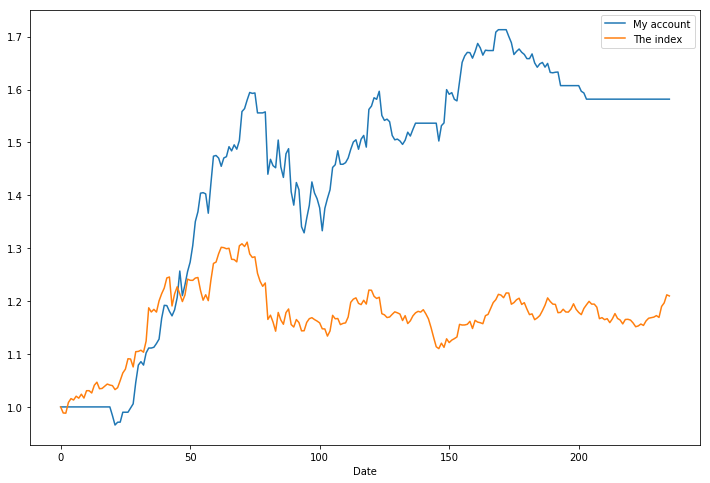

In [41]:
import Draw
reload(Draw)
%matplotlib inline
index_value = list(index_df[index_df['trade_date']==test_date_min+1]['pre_close']) + list(index_df.sort_values('trade_date')['close'])
Draw.Draw_Market_Value_Change(0, account.market_value_all, index_value)

In [46]:
num = 0
for ts_code, buy_date, sell_date in zip(account.info['ts_code'], account.info['buy_date'], account.info['sell_date']):
    Draw.Draw_Stock(ts_code, stock_info, buy_date, sell_date, left_offset=10, right_offset=30)
    num = num + 1
    if num > 60:
#         break

SyntaxError: unexpected EOF while parsing (<ipython-input-46-5a1b83c6a01b>, line 6)